In [2]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [3]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [4]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [5]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [69]:
print(1/.01)

100.0


In [72]:
m_true = 0.0
b_true = .5

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
scale_true = .0001

In [73]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, scale = theta
    a2 = 1.0 - a1
    delty1 = 0
    delty2 = 0.3
#     sigsq1 = .01
    sigsq2 = (1/sigsq1) * scale
    mod1 = y + delty1 - m*x - b
    mod2 = y + delty2 - m*x - b
#     return np.sum(np.log(a1/np.sqrt(2*np.pi*sigsq1))) - np.sum(-((mod1)**2)/(2*sigsq1)) \
#         + np.sum(np.log(1-(a2/a1)*(np.sqrt(sigsq1/sigsq2))*((sigsq1*(mod1)**2+sigsq2*(mod2)**2)/(2*sigsq1*sigsq2))))
    return np.sum(np.log(((a1/(np.sqrt(2*np.pi*sigsq1)))*np.exp((-(mod1)**2)/(2*sigsq1))+ \
                           ((a2/(np.sqrt(2*np.pi*sigsq2)))*np.exp((-(mod2)**2)/(2*sigsq2)) ))))

In [74]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, delty1_true, delty2_true, sigsq1_true, sigsq2_true, a1_true, scale_true], args=(days, planets_etamb))
m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml, scale_ml = result["x"]

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


In [75]:
print(m_ml, b_ml, delty1_ml, delty2_ml, sigsq1_ml, sigsq2_ml, a1_ml)

0.0 0.5 0.0 0.3 0.01 0.04 0.5


In [76]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, scale = theta
    if 0.0 < b < 1.0 and 0.0 < a1 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and scale > 0.0:
        pri_m = norm.logpdf(m, 0.0, 1.0)
#         pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
#         pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
#         pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = halfnorm.logpdf(a1, 0.0, 1.0/3.0)
        pri_scale = norm.logpdf(scale, .0001, .0001)
        return pri_m +pri_sigsq1 + pri_a1
    return -np.inf

In [77]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [78]:
ndim, nwalkers = 8, 200
# pos = [result["x"] + np.random.randn(ndim)*1e-4*[.2, .1, .5, .3, .3] for i in range(nwalkers)] #nwalkers x ndim entries
pos = [np.random.randn(ndim)*1e-4*[0.001, .6, 0.0, 0.3, .01, .04, .5, .5] for i in range(nwalkers)]

In [79]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb), threads=4, a=2.0)

In [80]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ -1.06492893e-06,   5.69881626e-01,   0.00000000e+00, ...,
           4.13247729e-01,   8.46813285e-01,   8.35834126e-05],
        [ -6.39744838e-06,   5.72773951e-01,   0.00000000e+00, ...,
           5.68648745e-01,   8.68822894e-01,   1.50386900e-04],
        [  6.42326435e-06,   8.21496167e-01,   0.00000000e+00, ...,
           2.03366757e+01,   3.55519368e-03,   1.31700287e-04],
        ..., 
        [  1.21291032e-06,   5.62186115e-01,   0.00000000e+00, ...,
           1.70731821e+00,   8.79423051e-01,   1.03403273e-04],
        [  8.85541907e-06,   8.25975918e-01,   0.00000000e+00, ...,
           1.28165417e+01,   8.62833866e-03,   3.30440106e-04],
        [ -9.10035327e-07,   5.63821157e-01,   0.00000000e+00, ...,
           2.47044608e-01,   8.71337341e-01,   1.13736409e-04]]),
 array([ 486.84354953,  486.26566118,  401.83633698,  487.5169993 ,
         486.8823008 ,  486.92322404,  402.53680557,  400.92791352,
         489.79288291,  485.9582098 ,  488.83934854,  48

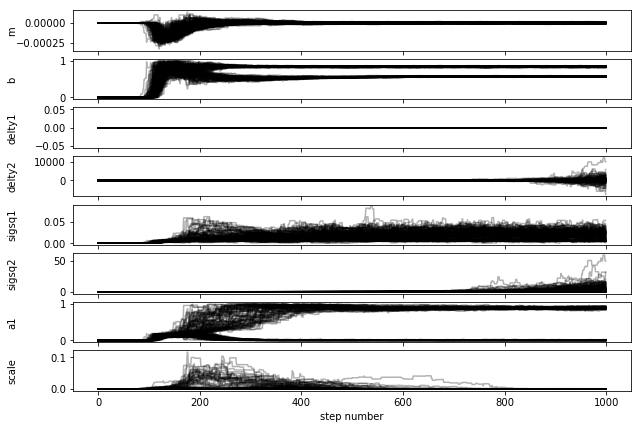

In [81]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "scale"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
    #(nwalkers, nsteps, dim)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_2gauss_corr.png")
plt.show()

In [82]:
flat_samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

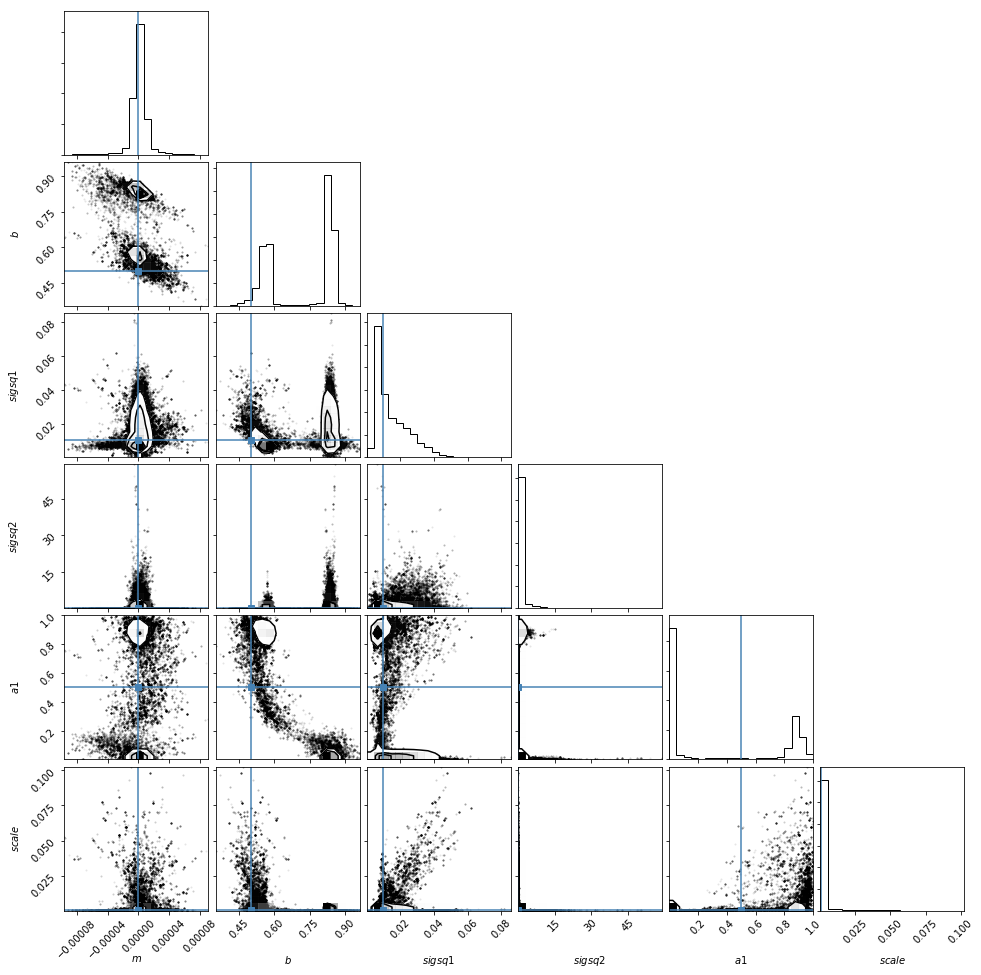

In [83]:
fig = corner.corner(flat_samples[:,[0, 1, 4, 5, 6, 7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$scale$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, scale_true])
fig.savefig("200walkers_smallinit_a2.0_1000steps_nongauss_noscatter_corner_2gauss_corr.png")

In [84]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

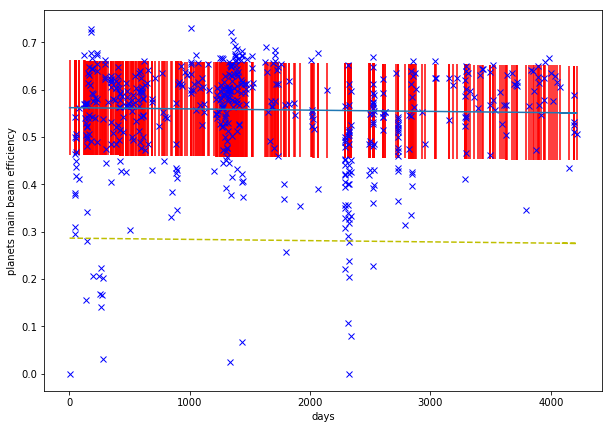

In [19]:
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
y = m*days + b
yerr = np.sqrt(.01)
bias = results[3][1]
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
plt.errorbar(days, y, yerr=yerr, ecolor='red')
plt.plot(days, y - bias, '--', color='y')
plt.show()